# Testing the new batch on Pi4 : `20190713a`

In [1]:

import json
import time
import datetime
import os,glob
import sys,re
import spidev
import numpy as np
import matplotlib.pyplot as plt

In [8]:
class us_json:
    """
        Class used to process data once acquired.
    """
    metatags = {}
    show_images = True
    IDLine = []
    TT1 = []
    TT2 = []
    tmp = []
    tdac = []
    FFT_x = []
    FFT_y = []
    EnvHil = []
    Duration = 0
    filtered_fft = []
    LengthT = 0
    Nacq = 0
    Raw = []
    Signal = []
    filtered_signal = []
    Registers = {}
    t = []
    fPiezo = 5
    Bandwidth = 1.0
    f = 0 # sampling freq
    piezo = ""
    experiment = ""
    len_acq = 0
    len_line = 0
    N = 0
    V = 0
    single = 0
    processed = False
    iD = 0
    raw_2d_image = []

    metatags["firmware_md5"] = ""

    def JSONprocessing(self, path):
        """
            Creates actual raw data from the signals acquired.
        """
        IDLine = []
        TT1 = []
        TT2 = []
        tmp = []
        tdac = []

        with open(path) as json_data:
            #DATA = {}
            d = json.load(json_data)
            json_data.close()

            self.description = d["experiment"]["description"]
            self.piezo = d["experiment"]["probe"]
            self.metatags["time"] = d["time"]
            self.metatags["original_json"] = d

            A = d["data"]
            #print d.keys()
            for i in range(int(len(A)/2)-1):
                if (A[2*i+1]) < 128:
                #print "first"
                    value = 128*(A[2*i+0]&0b0000111) + A[2*i+1] - 512
                    IDLine.append(((A[2*i+0]&0b11110000)/16  -8) /2) # Identify the # of the line
                    TT1.append((A[2*i+0] & 0b00001000) / 0b1000)
                    TT2.append((A[2*i+0] & 0b00010000) / 0b10000)
                    tmp.append(2.0*value/512.0)
                else:
                #print "second"
                    value = 128*(A[2*i+1]&0b111) + A[2*i+2] - 512
                    IDLine.append(((A[2*i+1]&0b11110000)/16 -8) /2) # Identify the # of the line
                    TT1.append((A[2*i+1] & 0b00001000) / 0b1000)
                    TT2.append((A[2*i+1] & 0b00010000) / 0b10000)
                    tmp.append(2.0*value/512.0)
            print("Data acquired")
            self.Registers = d["registers"]
            self.timings = d["timings"]
            self.f = float(64/((1.0+int(d["registers"]["237"]))))

            t = [1.0*x/self.f + self.timings['t4']/1000.0  for x in range(len(tmp))]
            self.t = t

            for i in range(len(IDLine)):
                if IDLine[i] < 0:
                    IDLine[i] = 0
            self.LengthT = len(t)

            #self.EnvHil = self.filtered_signal
            #self.EnvHil = np.asarray(np.abs(signal.rrt(self.filtered_signal)))

            self.TT1 = TT1
            self.TT2 = TT2
            self.Nacq = d["timings"]["NLines"]
            self.len_acq = len(self.t)
            self.len_line = int(self.len_acq/self.Nacq)


            # Precising the DAC
            REG = [int(x) for x in d["registers"].keys() if int(x) < 100]
            REG.sort()
            dac = []
            for k in REG:
                dac.append(d["registers"][str(k)])
            # Building the DAC timeline
            tdac = []
            for pts in t[0:self.len_line]: # @todo -> corriger pour avoir une ligne de 200us
                i = int(pts/5.0) # time in us

                try:
                    tdac.append(4.0*d["registers"][str(i+16)])
                except:
                    tdac.append(-1)

            # Updating the JSON
            self.tdac = tdac
            self.tmp = tmp
            self.single = d["registers"][str(0XEB)]
            self.t = t
            self.IDLine = IDLine
            self.metatags["firmware_md5"] = d['firmware_md5']
            self.experiment = d['experiment']
            self.parameters = d['parameters']
            self.iD = d['experiment']["id"]
            self.N = d['N']
            self.V = d['V']
            self.processed = True
            self.Duration = (self.parameters['LengthAcq']-self.parameters['DeltaAcq'])/1000.0

    def create_fft(self):
        self.FFT_x = [X*self.f / (self.LengthT) for X in range(self.LengthT)]
        self.FFT_y = np.fft.fft(self.tmp)
        self.filtered_fft = np.fft.fft(self.tmp)

        for k in range(int(self.LengthT/2) + 1):
            if k < (self.LengthT * self.fPiezo * (1 - self.Bandwidth/2.0) / self.f):
                self.filtered_fft[k] = 0
                self.filtered_fft[-k] = 0
            if k > (self.LengthT * self.fPiezo *(1 + self.Bandwidth/2.0) / self.f):
                self.filtered_fft[k] = 0
                self.filtered_fft[-k] = 0

        self.filtered_signal = np.real(np.fft.ifft(self.filtered_fft))

        if self.processed:
            plt.figure(figsize=(15, 5))

            plot_time = self.FFT_x[1:int(self.LengthT/2)]
            plot_abs_fft = np.abs(self.FFT_y[1:int(self.LengthT/2)])
            plot_filtered_fft = np.abs(self.filtered_fft[1:int(self.LengthT/2)])

            plt.plot(plot_time, plot_abs_fft, 'b-')
            plt.plot(plot_time, plot_filtered_fft, 'y-')

            plt.title("FFT of "+self.iD + " - acq. #: "+ str(self.N))
            plt.xlabel('Freq (MHz)')
            plt.tight_layout()
            file_name = "images/"+self.iD+"-"+str(self.N)+"-fft.jpg"
            plt.savefig(file_name)
            if self.show_images:
                plt.show()
            description_experiment = "FFT of the of "+self.iD
            description_experiment += " experiment. "+self.experiment["description"]
            #tag_image(file_name,"matty, cletus", self.iD, "FFT", description_experiment)



    def mkImg(self):
        """
           Makes an image from the JSON content 
        """
        if self.processed: #@todo check this to get env & al
            fig, ax1 = plt.subplots(figsize=(20, 10))
            ax2 = ax1.twinx()
            ax2.plot(self.t[0:self.len_line], self.tdac[0:self.len_line], 'g-')
            ax1.plot(self.t[0:self.len_line], self.tmp[0:self.len_line], 'b-')
            plt.title(self.create_title_text())
            ax1.set_xlabel('Time (us)')
            ax1.set_ylabel('Signal from ADC (V)', color='b')
            ax2.set_ylabel('DAC output in mV (range 0 to 1V)', color='g')
            plt.tight_layout()
            file_name = "images/"+self.iD+"-"+str(self.N)+".jpg"
            plt.savefig(file_name)
            if self.show_images:
                plt.show()
            #tag_image(file_name,"matty", self.iD, "graph", "Automated image of "+self.iD +" experiment. "+self.experiment["description"])

    def tag_image(self, bricks, experiment_id, img_type, img_desc,file_name):
        """
           Tags an image using available info.
        """
        #file_name = "images/"+self.iD+"-"+str(self.N)+".jpg"
    #@todo : create images folder if not exists
        if pyexivexists:
            metadata = pyexiv2.ImageMetadata(file_name)
            try:
                metadata.read()
            except IOError:
                print("Not an image")
            else:
                metadata['Exif.Image.Software'] = bricks
                metadata['Exif.Image.Make'] = experiment_id
                metadata['Exif.Photo.MakerNote'] = img_type
                metadata['Exif.Image.ImageDescription'] = img_desc
                metadata.write()
        else:
            print("pyexiv does not exist")

    def mk2DArray(self):
        """
           Creates a 2D array from raw json.
        """
        len_acquisition = len(self.tmp)
        img = []
        tmpline = []
        lineindex = 0

        for k in range(len_acquisition):
            if self.IDLine[k] != lineindex:
                img.append(tmpline)
                lineindex = self.IDLine[k]
                tmpline = []
            else:
                tmpline.append(self.tmp[k])

        duration_self = int(float(self.f)*self.Duration)

        y = [s for s in img if (len(s) > duration_self-10 and len(s) < duration_self+10)]
        if self.Nacq > 1:
            clean_image = np.zeros((len(y), len(self.tmp)/len(y)))
        else:
            clean_image = np.zeros((len(y),1))

        for i in range(len(y)):
            clean_image[i][0:len(y[i])] = y[i]

        img_size = np.shape(clean_image)
        #str(float(self.f)*Duration)
        Duration = (self.parameters['LengthAcq']-self.parameters['DeltaAcq'])/1000.0

        clean_image = clean_image[:, :int(Duration*self.f)]
        plt.figure(figsize=(15, 10))
        if self.Nacq > 1:
            #print img_size[1],img_size[0]
            plt.imshow(np.sqrt(np.abs(clean_image)), cmap='gray', aspect=0.5*(img_size[1]/img_size[0]), interpolation='nearest')
        else:
            plt.plot(self.t[0:self.len_line], self.tmp[0:self.len_line], 'b-')
            #plt.show()

        plt.title(self.create_title_text())
        #plt.colorbar(im, orientation='vertical')
        plt.tight_layout()
        file_name = "images/2DArray_"+self.iD+"-"+str(self.N)+".jpg"
        plt.savefig(file_name)
        #tag_image(file_name, "matty, "+self.piezo, self.iD, "BC", self.create_title_text().replace("\n", ". "))
        if self.show_images:
            plt.show()
        self.raw_2d_image = clean_image #@todo: reuse this 2D image ?

        return clean_image

    def save_npz(self):
        """
           Saves the dataset as an NPZ, in the data folder.
        """
        path_npz = "data/"+self.iD+"-"+str(self.N)+".npz" # @todo: create folder if not.
        np.savez(path_npz, self) 

    def plot_detail(self, nb_line, Start, Stop): #@todo: use it when processing data
        """
           Shows and displays a given line, with start and stop boundaries.
        """
        #TLine = self.len_line/self.f #@unused
        Offset = nb_line*self.len_line

        plot_time_series = self.t[Offset+int(Start/self.f):Offset+int(Stop*self.f)]
        plot_signal = self.tmp[Offset+int(Start/self.f):int(Stop*self.f)]
        #@todo .. what happens if no EnvHil ?
        plot_enveloppe = self.EnvHil[Offset+int(Start/self.f):int(Stop*self.f)]

        plot_title = "Detail of "+self.iD + " - acq. #: "+ str(self.N)+", between "
        plot_title += str(Start)+" and "+str(Stop)+" (line #"+str(nb_line)+")."

        plt.figure(figsize=(15, 5))
        plt.plot(plot_time_series, plot_signal, 'b-')
        plt.plot(plot_time_series, plot_enveloppe, 'y-')
        plt.title(plot_title)
        plt.xlabel('Time in us')
        plt.tight_layout()

        file_name = "images/detail_"+self.iD+"-"+str(self.N)+"-"
        file_name += str(Start)+"-"+str(Stop)+"-line"+str(nb_line)+".jpg"
        plt.savefig(file_name)
        if self.show_images:
            plt.show()



    def mkFiltered(self, original_image):
        """
           Takes the image, then filters it around self.fPiezo .
        """
        filtered_image = []
        fft_image_filtered = []
        if len(original_image):
            num_lines, length_lines = np.shape(original_image)
            f_array = [X*self.f / length_lines for X in range(length_lines)]
            for k in range(num_lines): # number of images
                fft_single_line = np.fft.fft(original_image[k])
                fft_image_filtered.append(fft_single_line)
                for p in range(len(fft_single_line)/2+1):
                    f_min = (1000.0 * self.fPiezo * 0.7)
                    f_max = (1000.0 * self.fPiezo * 1.27)
                    if (f_array[p] > f_max or f_array[p] < f_min):
                        fft_single_line[p] = 0
                        fft_single_line[-p] = 0
                filtered_image.append(np.real(np.fft.ifft(fft_single_line)))
        return filtered_image, fft_image_filtered

    def mkSpectrum(self, img):
        """
           Creates a 2D array spectrum from 2D image.
        """
        Spectrum = []
        #Filtered = [] #@unused
        if len(img):
            n_lines, len_lines = np.shape(img)
            self.FFT_x = [X*self.f / len_lines for X in range(len_lines)] #@usuned, why?
            for k in range(n_lines):
                fft_single_line = np.fft.fft(img[k])
                Spectrum.append(fft_single_line[0:n_lines/2])

            plt.figure(figsize=(15, 10))
            plt.imshow(np.sqrt(np.abs(Spectrum)), extent=[0, 1000.0*self.f/2, n_lines, 0], cmap='hsv', aspect=30.0, interpolation='nearest')

            plt.axvline(x=(1000 * self.fPiezo * 1.27), linewidth=4, color='b')
            plt.axvline(x=(1000 * self.fPiezo * 0.7), linewidth=4, color='b')

            plt.xlabel("Frequency (kHz)")
            plt.ylabel("Lines #")
     
            plt.title(self.create_title_text())
            plt.tight_layout()

            file_name = "images/Spectrum_"+self.iD+"-"+str(self.N)+".jpg"
            plt.savefig(file_name)
            img_desc = self.create_title_text().replace("\n", ". ")
            #tag_image(file_name, "matty,"+self.piezo, self.iD, "FFT", img_desc)
        else:
            print("2D Array not created yet")

        return np.abs(Spectrum)

    def create_title_text(self):
        """
           Creates a string to title images with appropriate acquisition details
        """
        title_text = "Experiment: " +self.iD+"-"+str(self.N)+"\nDuration: "+str(self.Duration)
        title_text += "us ("+str(self.parameters['LengthAcq'])+" - "
        title_text += str(self.parameters['DeltaAcq'])+"), for "+str(self.Nacq)
        title_text += " repeats "
        title_text += "each "+str(self.parameters['PeriodAcq_Real']/1000.0)+"us\n"
        title_text += "Fech = "+str(self.f)+"Msps, total of "+str(float(self.f)*self.Duration)
        title_text += " pts per line, Nacq = "+str(self.Nacq)+"\n"
        title_text += self.experiment["description"]+", probe: "
        title_text += self.piezo+", target = "+self.experiment["target"]+"\n"
        title_text += "Timestamp = "+str(self.metatags["time"])
        return title_text


20190713a-1.json
Data acquired


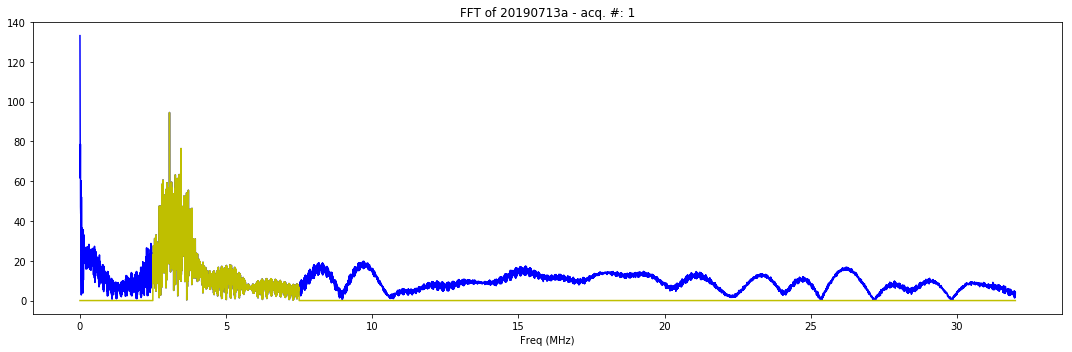

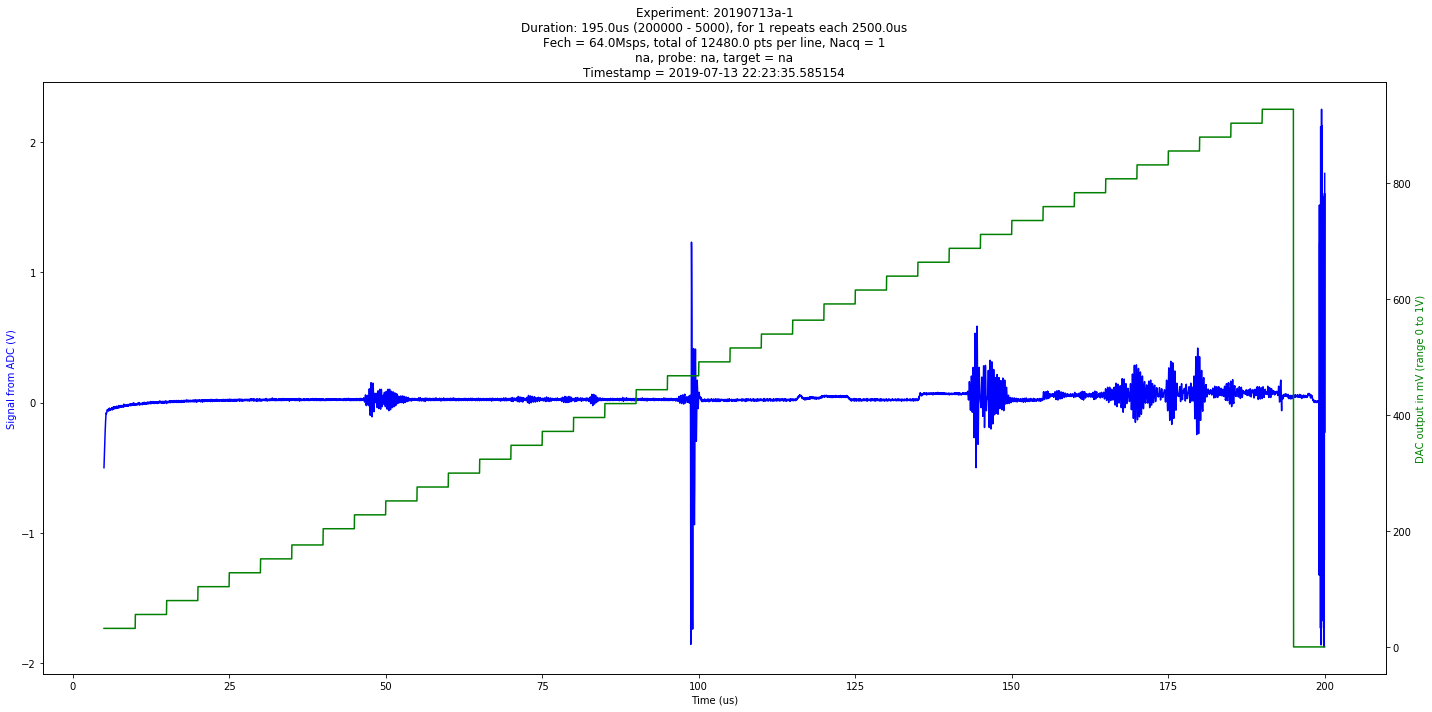

In [14]:
for MyDataFile in os.listdir("./"):
    if MyDataFile.endswith("1.json"):
        print(MyDataFile)
        y = us_json()
        y.show_images = False
        y.JSONprocessing("./"+MyDataFile)
        y.create_fft() 
        #y.save_npz() 
        y.mkImg() 